Курсовая работа

07. Классификация: превышает ли значение SI медианное значение выборки

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.1 MB/s eta 0:00:00


In [4]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import joblib
import optuna
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [6]:
# Загрузка  данных
df_standardscaler = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classic_ML_Vo_PJ/df_standardscaler.csv')

In [7]:
# Выведим размерность датафрейма
df_standardscaler.shape

(969, 188)

In [8]:
# Выведим первые строки датафрейма
df_standardscaler.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


In [9]:
# Выбираем целевую переменную — это SI
y = df_standardscaler['SI']  # Целевая переменная

# Рассчитываем медианное значение SI
median_SI = y.median()

# Преобразуем задачу регрессии в задачу бинарной классификации:
# - 1: если SI > median (высокое значение)
# - 0: если SI <= median (низкое значение)
y_binary = (y > median_SI).astype(int)  # Бинарная целевая переменная


# Формируем матрицу признаков, исключая SI, CC50, IC50
X = df_standardscaler.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки


# Разделяем данные на обучающую и тестовую выборки в соотношении 70:30
# random_state=42 — обеспечивает воспроизводимость результата
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary,
    test_size=0.3,
    random_state=42
)


# Словарь с классами классификаторов, которые будут оптимизироваться
CLASSIFIERS = {
    'XGBClassifier': XGBClassifier,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'RandomForestClassifier': RandomForestClassifier,
    'CatBoostClassifier': CatBoostClassifier
}


# Функция-объектив для Optuna, которая будет оценивать модель
def objective(trial, classifier_name):
    """ Функция для поиска гиперпараметров модели с помощью Optuna """

    if classifier_name == 'XGBClassifier':
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBClassifier(**params)

    elif classifier_name == 'DecisionTreeClassifier':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeClassifier(**params)

    elif classifier_name == 'RandomForestClassifier':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestClassifier(**params)

    elif classifier_name == 'CatBoostClassifier':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0  # Отключаем выводы обучения
        }
        model = CatBoostClassifier(**params)

    # Обучаем модель
    model.fit(X_train, y_train)

    # Делаем предсказания
    y_pred = model.predict(X_test)

    # Оцениваем качество по метрике accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy  # Возвращаем accuracy как цель оптимизации


# Хранение результатов оптимизации моделей
best_models = {}

# Проходимся по всем классификаторам из словаря CLASSIFIERS
for classifier_name in CLASSIFIERS.keys():
    print(f"Оптимизация гиперпараметров для {classifier_name}...")
    study = optuna.create_study(direction='maximize')  # Создаём исследование Optuna для максимизации accuracy
    study.optimize(lambda trial: objective(trial, classifier_name), n_trials=200)  # Ищем лучшие параметры

    best_params = study.best_params  # Получаем лучшие параметры
    best_model = CLASSIFIERS[classifier_name](**best_params).fit(X_train, y_train)  # Обучаем модель с этими параметрами
    best_models[classifier_name] = {
        'best_params': best_params,   # Лучшие гиперпараметры
        'best_model': best_model      # Лучшая обученная модель
    }

    print(f"Лучшие гиперпараметры для {classifier_name}:")
    print(best_params)


# Оценка качества моделей на тестовых данных
print("\n=== Результаты на тестовых данных ===\n")
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)

    # Подсчёт метрик
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Вывод результатов
    print(f"{classifier_name}")
    print(f"  Тестовая точность: {accuracy:.4f}")
    print(f"  Тестовый F1-score: {f1:.4f}\n")

[I 2025-06-12 17:15:52,324] A new study created in memory with name: no-name-64c9fae4-a527-43af-a566-c7bb5c697269


Оптимизация гиперпараметров для XGBClassifier...


[I 2025-06-12 17:15:57,337] Trial 0 finished with value: 0.6632302405498282 and parameters: {'learning_rate': 0.00039530779915072624, 'max_depth': 6, 'n_estimators': 332, 'subsample': 0.8158322118838619, 'colsample_bytree': 0.9508115944156149}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-12 17:16:05,069] Trial 1 finished with value: 0.6391752577319587 and parameters: {'learning_rate': 0.03167051460670338, 'max_depth': 9, 'n_estimators': 422, 'subsample': 0.6197421972020047, 'colsample_bytree': 0.5845289268522462}. Best is trial 0 with value: 0.6632302405498282.
[I 2025-06-12 17:16:09,593] Trial 2 finished with value: 0.6701030927835051 and parameters: {'learning_rate': 0.00011278941862211217, 'max_depth': 11, 'n_estimators': 318, 'subsample': 0.6039075301585586, 'colsample_bytree': 0.5442892694208072}. Best is trial 2 with value: 0.6701030927835051.
[I 2025-06-12 17:16:10,492] Trial 3 finished with value: 0.6735395189003437 and parameters: {'learning_rate': 0.00461556844

Лучшие гиперпараметры для XGBClassifier:
{'learning_rate': 0.00019759722421886902, 'max_depth': 14, 'n_estimators': 93, 'subsample': 0.6061078685369536, 'colsample_bytree': 0.6519546791624513}
Оптимизация гиперпараметров для DecisionTreeClassifier...


[I 2025-06-12 17:25:31,906] Trial 4 finished with value: 0.563573883161512 and parameters: {'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.6219931271477663.
[I 2025-06-12 17:25:31,937] Trial 5 finished with value: 0.5773195876288659 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.6219931271477663.
[I 2025-06-12 17:25:31,989] Trial 6 finished with value: 0.5773195876288659 and parameters: {'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.6219931271477663.
[I 2025-06-12 17:25:32,030] Trial 7 finished with value: 0.6288659793814433 and parameters: {'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.6288659793814433.
[I 2025-06-12 17:25:32,084] Trial 8 finished with value: 0.6151202749140894 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 7 with 

Лучшие гиперпараметры для DecisionTreeClassifier:
{'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}
Оптимизация гиперпараметров для RandomForestClassifier...


[I 2025-06-12 17:25:45,624] Trial 0 finished with value: 0.6735395189003437 and parameters: {'n_estimators': 160, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6735395189003437.
[I 2025-06-12 17:25:46,637] Trial 1 finished with value: 0.6151202749140894 and parameters: {'n_estimators': 501, 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6735395189003437.
[I 2025-06-12 17:25:47,622] Trial 2 finished with value: 0.6701030927835051 and parameters: {'n_estimators': 191, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.6735395189003437.
[I 2025-06-12 17:25:48,524] Trial 3 finished with value: 0.6151202749140894 and parameters: {'n_estimators': 451, 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6735395189003437.
[I 2025-06-12 17:25:49,804] Trial 4 finished with value: 0.6597938144329897 and parameters: {'

Лучшие гиперпараметры для RandomForestClassifier:
{'n_estimators': 155, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 10}
Оптимизация гиперпараметров для CatBoostClassifier...


[I 2025-06-12 17:29:30,335] Trial 0 finished with value: 0.6185567010309279 and parameters: {'learning_rate': 0.000986859448526192, 'depth': 2, 'iterations': 94, 'l2_leaf_reg': 0.22164315303567708}. Best is trial 0 with value: 0.6185567010309279.
[I 2025-06-12 17:29:37,195] Trial 1 finished with value: 0.6632302405498282 and parameters: {'learning_rate': 0.0001661542232855934, 'depth': 6, 'iterations': 321, 'l2_leaf_reg': 0.023361973751082975}. Best is trial 1 with value: 0.6632302405498282.
[I 2025-06-12 17:29:42,840] Trial 2 finished with value: 0.6529209621993127 and parameters: {'learning_rate': 0.03663476983891683, 'depth': 5, 'iterations': 257, 'l2_leaf_reg': 1.7714219032717093}. Best is trial 1 with value: 0.6632302405498282.
[I 2025-06-12 17:29:50,199] Trial 3 finished with value: 0.6769759450171822 and parameters: {'learning_rate': 0.0012843502180977487, 'depth': 5, 'iterations': 547, 'l2_leaf_reg': 0.00033503197787590835}. Best is trial 3 with value: 0.6769759450171822.
[I 20

0:	learn: 0.6905460	total: 35.9ms	remaining: 16.7s
1:	learn: 0.6885892	total: 72.2ms	remaining: 16.8s
2:	learn: 0.6858427	total: 113ms	remaining: 17.4s
3:	learn: 0.6832271	total: 149ms	remaining: 17.3s
4:	learn: 0.6808202	total: 186ms	remaining: 17.2s
5:	learn: 0.6784656	total: 219ms	remaining: 16.8s
6:	learn: 0.6762004	total: 263ms	remaining: 17.3s
7:	learn: 0.6732088	total: 299ms	remaining: 17.2s
8:	learn: 0.6713739	total: 334ms	remaining: 17s
9:	learn: 0.6687648	total: 368ms	remaining: 16.8s
10:	learn: 0.6664576	total: 403ms	remaining: 16.7s
11:	learn: 0.6635352	total: 437ms	remaining: 16.6s
12:	learn: 0.6602460	total: 476ms	remaining: 16.6s
13:	learn: 0.6582153	total: 513ms	remaining: 16.6s
14:	learn: 0.6566217	total: 548ms	remaining: 16.5s
15:	learn: 0.6547351	total: 588ms	remaining: 16.6s
16:	learn: 0.6519356	total: 637ms	remaining: 16.9s
17:	learn: 0.6495301	total: 671ms	remaining: 16.7s
18:	learn: 0.6469102	total: 710ms	remaining: 16.7s
19:	learn: 0.6454962	total: 744ms	remaini

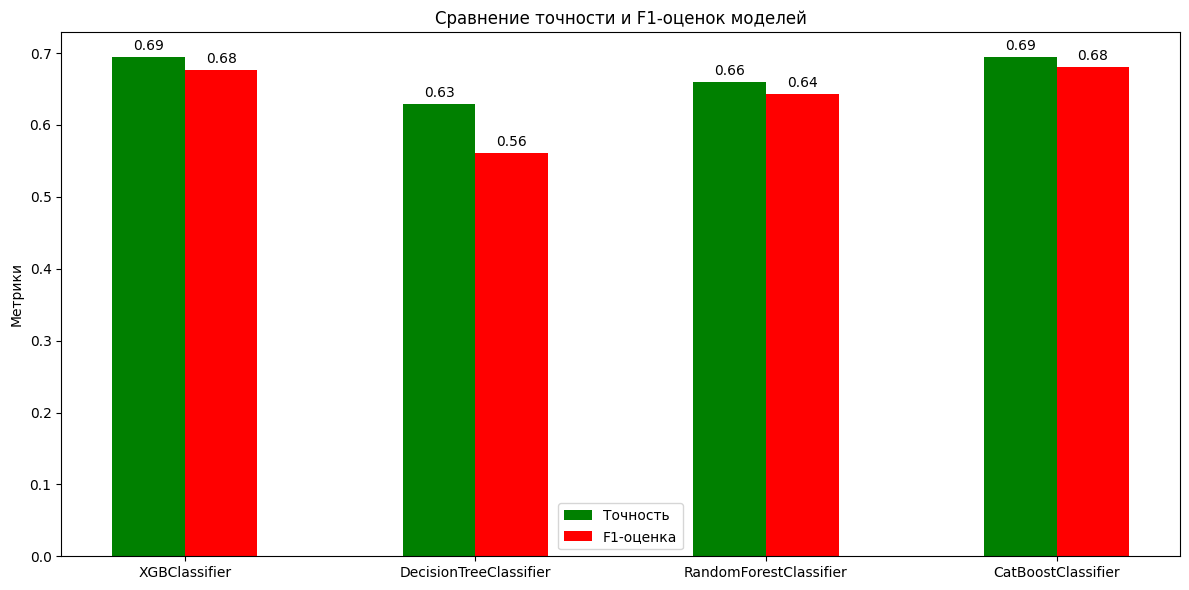

In [10]:
# Списки для хранения метрик моделей: точности (accuracy) и F1-оценки
models_names = list(best_models.keys())  # Получаем названия всех моделей из best_models
accuracies = []  # Список для сохранения значений accuracy
f1_scores = []   # Список для сохранения значений F1-score

# Цикл для вычисления метрик для каждой модели
for classifier_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)

    # Вычисляем метрики
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Добавляем результаты в списки
    accuracies.append(accuracy)
    f1_scores.append(f1)


x = np.arange(len(models_names))  # Массив индексов для размещения столбцов
width = 0.25
# Создаём график размером 12x6
fig, ax = plt.subplots(figsize=(12, 6))

# Строим два набора столбцов:
bars1 = ax.bar(x - width/2, accuracies, width, label='Точность', color='green')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-оценка', color='red')

# Настраиваем ось Y и заголовок графика
ax.set_ylabel('Метрики')
ax.set_title('Сравнение точности и F1-оценок моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()


# Функция для добавления численных значений на верхушку каждого столбца
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Добавляем значения на обе группы столбцов
add_labels(bars1)
add_labels(bars2)

plt.tight_layout()

# Отображаем график
plt.show()

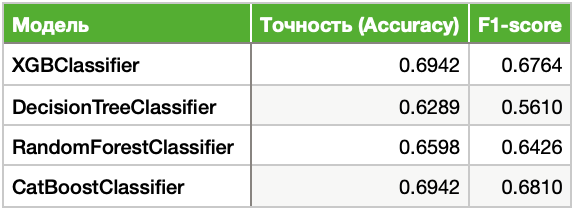


1. CatBoostClassifier показывает наилучшие результаты, имеет наивысший F1-score, что говорит о хорошем балансе между precision и recall.
Уровень точности (Accuracy) у CatBoost совпадает с XGBoost, но F1 немного выше, что делает его предпочтительным.


2. XGBoostClassifier демонстрирует высокую стабильность, имеет точность 0.6942, равную CatBoost. F1-score чуть ниже, но всё же достаточно хорош.
Это указывает на то, что модель хорошо справляется с задачей.


3. RandomForestClassifier имеет средние результаты, показывает ниже Accuracy и F1, чем CatBoost и XGBoost. Однако он остаётся более устойчивым к переобучению и может быть полезен в случае, если важна интерпретируемость модели или её работоспособность при наличии шума.


4. DecisionTreeClassifier значительно хуже остальных моделей, имеет самый низкий Accuracy и F1-score, что указывает на недообучение или переобучение.


Вывод:

- CatBoostClassifier — лучшая модель по метрикам качества среди всех рассмотренных, использовать как основную модель для дальнейших предсказаний.

- XGBoostClassifier — надёжная альтернатива CatBoostClassifier.

- RandomForestClassifier — подходящий вариант, если требуется компромисс между качеством и интерпретируемостью.

- DecisionTreeClassifier не рекомендуется использовать как основную модель в этой задаче.


In [11]:
def save_model(model, model_name):
    """ Сохраняет модель в файл с расширением .pkl """
    filename = f"{model_name}_SI.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
        print(f"Модель '{filename}' сохранена.")


def load_model(model_name):
    """ Загружает ранее сохранённую модель из файла """
    filename = f"{model_name}_SI.pkl"
    try:
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        print(f"Модель '{filename}' загружена.")
        return model
    except FileNotFoundError:
        print(f"Ошибка: файл '{filename}' не найден.")  # Сообщаем об ошибке, если файл отсутствует
        return None  # Возвращаем None при ошибке


# Сохраняем каждую из оптимальных моделей в отдельный файл
for classifier_name, model_data in best_models.items():
    save_model(model_data['best_model'], classifier_name)


# Загружаем все модели обратно из файлов
loaded_models = {
    'XGBClassifier': load_model('XGBClassifier'),
    'DecisionTreeClassifier': load_model('DecisionTreeClassifier'),
    'RandomForestClassifier': load_model('RandomForestClassifier'),
    'CatBoostClassifier': load_model('CatBoostClassifier')
}

Модель 'XGBClassifier_SI.pkl' сохранена.
Модель 'DecisionTreeClassifier_SI.pkl' сохранена.
Модель 'RandomForestClassifier_SI.pkl' сохранена.
Модель 'CatBoostClassifier_SI.pkl' сохранена.
Модель 'XGBClassifier_SI.pkl' загружена.
Модель 'DecisionTreeClassifier_SI.pkl' загружена.
Модель 'RandomForestClassifier_SI.pkl' загружена.
Модель 'CatBoostClassifier_SI.pkl' загружена.


In [12]:
import os
# Проверяем все файлы в текущей директории
os.listdir()

['.config',
 'XGBClassifier_SI.pkl',
 'drive',
 'DecisionTreeClassifier_SI.pkl',
 'catboost_info',
 'RandomForestClassifier_SI.pkl',
 'CatBoostClassifier_SI.pkl',
 'sample_data']